In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
class ConvBnLeakyReLU(nn.Module):
    """
    [CONV]-[BN]-[LeakyReLU]
    """
    def __init__(self, inCh, outCh, kernel):
        super(ConvBnLeakyReLU, self).__init__()
        self.inCh = inCh  # Number of input channels
        self.outCh = outCh  # Number of output channels
        self.kernel = kernel  # Kernel size
        padding = (self.kernel - 1) // 2 
        self.conv = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, kernel, stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(outCh),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    

class YOLOv3Params():
    """
    Parameters for MobileNetV2
    """
    def __init__(self):
        self.n_classes = 4  # Udacity Self-driving car dataset
        self.final_channels = 3 * (5 + self.n_classes)
        self.class_names = ['car', 'truck', 'pedestrian', 'signal']
        self.anchors = [[10, 13], [16, 30], [33, 23], 
                        [30, 61], [62, 45], [59, 119], 
                        [116, 90], [156, 198], [373, 326]]
        self.mode = "infer"

In [3]:
# http://machinethink.net/blog/object-detection/
# Very helpful diagram: https://www.cyberailab.com/home/a-closer-look-at-yolov3
# https://github.com/marvis/pytorch-yolo3
# https://gitlab.com/EAVISE/lightnet/blob/master/lightnet/network/loss/_regionloss.py

### YOLO Layer

In [4]:
class YOLOv3Layer(nn.Module):
    """
    YOLOv3 Layer
    
    Reference: https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    """
    def __init__(self, params):
        super(YOLOv3Layer, self).__init__()
        self.params = params
        self.base = base_network(params)  # MobileNetV2
        self.base_out_channels = self.base.out_channels  # [256, 512, 1280]
        self.n_classes = self.params.n_classes 
        self.out_channels = 3 * (5 + self.n_classes)  # 3 x (B + C)
        self.anchors = np.array(params.anchors)
        self.n_layers = len(self.anchors) // 3
        self.loss = YOLOLoss(params)
        
        # Conv layer block for 13x13 feature maps from base network
        self.conv_block13 = self._make_conv_block(inCh=self.base_out_channels[-1],
                                                  channel_list=[512, 1024],
                                                  outCh=self.out_channels)
        
        # Conv layer block for 26x26 feature maps from base network
        self.conv26 = ConvBnLeakyReLU(inCh=512, outCh=256, kernel=1)
        self.conv_block26 = self._make_conv_block(inCh=self.base_out_channels[-2] + 256,
                                                  channel_list=[256, 512],
                                                  outCh=self.out_channels)
        
        # Conv layer block for 52x52 feature maps from base network
        self.conv52 = ConvBnLeakyReLU(inCh=256, outCh=128, kernel=1)
        self.conv_block52 = self._make_conv_block(inCh=self.base_out_channels[-3] + 128,
                                                  channel_list=[128, 256],
                                                  outCh=self.out_channels)
        
    def _make_conv_block(self, inCh, channel_list, outCh):
        """Outputs from Base is passed through a few ConvBNReLU layers"""
        modList = nn.ModuleList([
            ConvBnLeakyReLU(inCh, channel_list[0], kernel=1),
            ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
            ConvBnLeakyReLU(channel_list[1], channel_list[0], kernel=1),
            ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
            ConvBnLeakyReLU(channel_list[1], channel_list[0], kernel=1),
            ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
        ])
        modList.add_module("ConvOut", nn.Conv2d(channel_list[1], outCh, 
                                                kernel_size=1, stride=1, 
                                                padding=0, bias=True))
        
        return modList
    
    def _route(self, in_feature, conv_block):
        for i, conv_module in enumerate(conv_block):
            in_feature = conv_module(in_feature)
            if i == 4:
                route = in_feature
        return in_feature, route
    
    def forward(self, img, label13, label26, label52):
        # Output from base network
        x52, x26, x13 = self.base(img)
        
        # Forward pass
        out13, out13_route = self._route(x13, self.conv_block13)  # size: 13x13
        
        # YOLO branch 1
        x26_in = self.conv26(out13_route)  # size: 13x13
        x26_in = F.interpolate(x26_in, scale_factor=2, mode='nearest')  # size: 13x13 -> 26x26
        x26_in = torch.cat([x26_in, x26], dim=1)
        out26, out26_route = self._route(x26_in, self.conv_block26)  # size: 26x26
        
        # YOLO branch 2
        x52_in = self.conv52(out26_route)  # size: 26x26
        x52_in = F.interpolate(x52_in, scale_factor=2, mode='nearest')  # size: 26x26 -> 52x52
        x52_in = torch.cat([x52_in, x52], dim=1)
        out52, out52_route = self._route(x52_in, self.conv_block52)  # size: 52x52
        
        # Compute loss
        loss = self.loss((out13, out26, out52), (label13, label26, label52))
        
        return loss
    
    def detect(self, img, img_shape):
        """
        img: array
        img_shape: array
        """
        with torch.no_grad():
            # Output from base network
            x52, x26, x13 = self.base(img)

            # Forward pass
            out13, out13_route = self._route(x13, self.conv_block13)  # size: 13x13

            # YOLO branch 1
            x26_in = self.conv26(out13_route)  # size: 13x13
            x26_in = F.interpolate(x26_in, scale_factor=2, mode='nearest')  # size: 13x13 -> 26x26
            x26_in = torch.cat([x26_in, x26], dim=1)
            out26, out26_route = self._route(x26_in, self.conv_block26)  # size: 26x26

            # YOLO branch 2
            x52_in = self.conv52(out26_route)  # size: 26x26
            x52_in = F.interpolate(x52_in, scale_factor=2, mode='nearest')  # size: 26x26 -> 52x52
            x52_in = torch.cat([x52_in, x52], dim=1)
            out52, out52_route = self._route(x52_in, self.conv_block52)  # size: 52x52
            
        # Detect
        dets, img_indices, classes = yolo_eval((out13, out26, out52), self.anchors, self.n_classes, img_shape)
        
        return dets, img_indices, classes

### YOLO Layer Scratch

Outputs from MobileNetV2

```
52x52 size feature map:  torch.Size([1, 256, 52, 52])
26x26 size feature map:  torch.Size([1, 512, 26, 26])
13x13 size feature map:  torch.Size([1, 1280, 13, 13])
```

In [13]:
kernel = 3
p = (kernel - 1) // 2
print(p)

1


In [14]:
y52 = torch.randn([1, 256, 52, 52])
y26 = torch.randn([1, 512, 26, 26])
y13 = torch.randn([1, 1280, 13, 13])

In [15]:
# 13 x 13
final_channels = 3 * (5 + 4)
outCh_list = [256, 512, 1280]

inCh = outCh_list[-1]
channel_list = [512, 1024]

convBlock13 = nn.ModuleList([
    ConvBnLeakyReLU(inCh, channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], final_channels, 1),
])

print(convBlock13[0])

in13 = y13
for i, conv in enumerate(convBlock13):
    in13 = conv(in13)
    print('i: {} and in13 size: {}'.format(i, in13.size()))
    if i == 4:
        out_route13 = in13
out13 = in13
print(out13.size())
print(out_route13.size())

ConvBnLeakyReLU(
  (conv): Sequential(
    (0): Conv2d(1280, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
)
i: 0 and in13 size: torch.Size([1, 512, 13, 13])
i: 1 and in13 size: torch.Size([1, 1024, 13, 13])
i: 2 and in13 size: torch.Size([1, 512, 13, 13])
i: 3 and in13 size: torch.Size([1, 1024, 13, 13])
i: 4 and in13 size: torch.Size([1, 512, 13, 13])
i: 5 and in13 size: torch.Size([1, 1024, 13, 13])
i: 6 and in13 size: torch.Size([1, 27, 13, 13])
torch.Size([1, 27, 13, 13])
torch.Size([1, 512, 13, 13])


```int26 = F.interpolate(in26, scale_factor=2, mode='bilinear', align_corners=False)``` - This seems to not work

In [16]:
# 26 x 26
final_channels = 3 * (5 + 4)
outCh_list = [256, 512, 1280]

inCh = outCh_list[-2] + 256
channel_list = [256, 512]

convBlock26 = nn.ModuleList([
    ConvBnLeakyReLU(inCh, channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], final_channels, 1),
])

print(convBlock26[0])

conv26 = ConvBnLeakyReLU(inCh=512, outCh=256, kernel=1)
in26 = conv26(out_route13)  # 13x13 -[UPSAMPLE: 2x]-> 26x26
print(in26.shape)

#upsample26 = nn.Upsample(scale_factor=2, mode='bilinear')
#in26 = upsample26(in26)

in26 = F.interpolate(in26, scale_factor=2, mode='nearest')
print('after upsample ', in26.shape)

in26 = torch.cat([in26, y26], dim=1)  # Concatenate
print(in26.shape)

for i, conv in enumerate(convBlock26):
    in26 = conv(in26)
    print('i: {} and in26 size: {}'.format(i, in26.size()))
    if i == 4:
        out_route26 = in26
        
out26 = in26
print(out26.size())
print(out_route26.size())

ConvBnLeakyReLU(
  (conv): Sequential(
    (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
)
torch.Size([1, 256, 13, 13])
after upsample  torch.Size([1, 256, 26, 26])
torch.Size([1, 768, 26, 26])
i: 0 and in26 size: torch.Size([1, 256, 26, 26])
i: 1 and in26 size: torch.Size([1, 512, 26, 26])
i: 2 and in26 size: torch.Size([1, 256, 26, 26])
i: 3 and in26 size: torch.Size([1, 512, 26, 26])
i: 4 and in26 size: torch.Size([1, 256, 26, 26])
i: 5 and in26 size: torch.Size([1, 512, 26, 26])
i: 6 and in26 size: torch.Size([1, 27, 26, 26])
torch.Size([1, 27, 26, 26])
torch.Size([1, 256, 26, 26])


In [17]:
# 52 x 52
final_channels = 3 * (5 + 4)
outCh_list = [256, 512, 1280]

inCh = outCh_list[-3] + 128
channel_list = [128, 256]

convBlock52 = nn.ModuleList([
    ConvBnLeakyReLU(inCh, channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], final_channels, 1),
])

print(convBlock52[0])

conv52 = ConvBnLeakyReLU(inCh=256, outCh=128, kernel=1)
in52 = conv52(out_route26)  # 26x26 -[UPSAMPLE: 2x]-> 52x52
print(in52.shape)
# upsample52 = nn.Upsample(scale_factor=2, mode='bilinear')
# in52 = upsample52(in52)
in52 = F.interpolate(in52, scale_factor=2, mode='nearest')
print(in52.shape)

in52 = torch.cat([in52, y52], dim=1)  # Concatenate
print(in52.shape)

for i, conv in enumerate(convBlock52):
    in52 = conv(in52)
    print('i: {} and in52 size: {}'.format(i, in52.size()))
    if i == 4:
        out_route52 = in52
        
out52 = in52
print(out52.size())
print('Ignored! ', out_route52.size())

ConvBnLeakyReLU(
  (conv): Sequential(
    (0): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
)
torch.Size([1, 128, 26, 26])
torch.Size([1, 128, 52, 52])
torch.Size([1, 384, 52, 52])
i: 0 and in52 size: torch.Size([1, 128, 52, 52])
i: 1 and in52 size: torch.Size([1, 256, 52, 52])
i: 2 and in52 size: torch.Size([1, 128, 52, 52])
i: 3 and in52 size: torch.Size([1, 256, 52, 52])
i: 4 and in52 size: torch.Size([1, 128, 52, 52])
i: 5 and in52 size: torch.Size([1, 256, 52, 52])
i: 6 and in52 size: torch.Size([1, 27, 52, 52])
torch.Size([1, 27, 52, 52])
Ignored!  torch.Size([1, 128, 52, 52])


In [18]:
def _make_conv_block(inCh, channel_list, outCh):
    """Outputs from Base is passed through a few ConvBNReLU layers"""
    modList = nn.ModuleList([
        ConvBnLeakyReLU(inCh, channel_list[0], kernel=1),
        ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
        ConvBnLeakyReLU(channel_list[1], channel_list[0], kernel=1),
        ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
        ConvBnLeakyReLU(channel_list[1], channel_list[0], kernel=1),
        ConvBnLeakyReLU(channel_list[0], channel_list[1], kernel=3),
    ])
    modList.add_module("ConvOut", nn.Conv2d(channel_list[1], outCh, 
                                            kernel_size=1, stride=1, 
                                            padding=0, bias=True))

    return modList

def _route(in_feature, conv_block):
    for i, conv_module in enumerate(conv_block):
        in_feature = conv_module(in_feature)
        print(i, in_feature.shape)
        if i == 4:
            route = in_feature
    return in_feature, route
    
def forward(x52, x26, x13):
    # Forward pass
    out13, out13_route = _route(x13, conv_block13)  # size: 13x13
    
    # YOLO branch 1
    x26_in = conv_block26(out13_route)  # size: 13x13
    x26_in = F.interpolate(x26_in, scale_factor=2, mode='nearest')  # size: 13x13 -> 26x26
    x26_in = torch.cat([x26_in, x26], dim=1)
    out26, out26_route = _route(x26_in, conv_block26)  # size: 26x26

    # YOLO branch 2
    x52_in = conv_block52(out26_route)  # size: 26x26
    x52_in = F.interpolate(x52_in, scale_factor=2, mode='nearest')  # size: 26x26 -> 52x52
    x52_in = torch.cat([x52_in, x52], dim=1)
    out52, out52_route = _route(x52_in, conv_block52)  # size: 52x52
    
    return out13, out26, out52

In [20]:
# 13 x 13
final_channels = 3 * (5 + 4)
outCh_list = [256, 512, 1280]

inCh = outCh_list[-1]
channel_list = [512, 1024]

convBlock13 = nn.ModuleList([
    ConvBnLeakyReLU(inCh, channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], channel_list[0], 1),
    ConvBnLeakyReLU(channel_list[0], channel_list[1], 3),
    ConvBnLeakyReLU(channel_list[1], final_channels, 1),
])

print(convBlock13[0])

in13 = y13
for i, conv in enumerate(convBlock13):
    in13 = conv(in13)
    print('i: {} and in13 size: {}'.format(i, in13.size()))
    if i == 4:
        out_route13 = in13
out13 = in13
print(out13.size())
print(out_route13.size())

ConvBnLeakyReLU(
  (conv): Sequential(
    (0): Conv2d(1280, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
)
i: 0 and in13 size: torch.Size([1, 512, 13, 13])
i: 1 and in13 size: torch.Size([1, 1024, 13, 13])
i: 2 and in13 size: torch.Size([1, 512, 13, 13])
i: 3 and in13 size: torch.Size([1, 1024, 13, 13])
i: 4 and in13 size: torch.Size([1, 512, 13, 13])
i: 5 and in13 size: torch.Size([1, 1024, 13, 13])
i: 6 and in13 size: torch.Size([1, 27, 13, 13])
torch.Size([1, 27, 13, 13])
torch.Size([1, 512, 13, 13])


In [21]:
print('x13 shape: ', x13.shape)
inCh = 1280
outCh = 3 * (5 + 5)
chList = [512, 1024]

c1 = ConvBnLeakyReLU(inCh, chList[0], kernel=1)
o1 = c1(x13)

x13 shape:  torch.Size([1, 1280, 13, 13])


# YOLO Bounding Box Preprocessing

In [10]:
import numpy as np


def preprocess_true_boxes(true_boxes, input_shape, anchors, n_classes):
    """
    Preprocess true bounding boxes to training input format.
    
    Reference: https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
    
    Parameters
    ----------
    true_boxes: Numpy array of shape = (N, T, 5), where N: Number of images,
        T: Number of maximum objects in an image, and 5 corresponds to absolute
        x_min, y_min, x_max, y_max (values relative to input_shape) and number of
        classes.
    input_shape: list, [height, width] and length = 2. NOTE: height and width are 
        multiples of 32
    anchors: Numpy array of shape = (9, 2), and array is of form [width, height]
    n_classes: int, number of classes
    
    Return
    ------
    y_true: list of 3 Numpy arrays, [(n, 13, 13, 3, 5 + c), ...]
    """
    # Check: class_id in true_boxes must be less than n_classes
    assert (true_boxes[..., 4] < n_classes).all()
    
    # Create masks for anchors
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    
    # Number of scales
    num_scales = len(anchors) // 3
    
    # Convert true_boxes values to float and convert input_shape list to numpy array
    true_boxes = np.array(true_boxes, dtype=np.float32)
    input_shape = np.array(input_shape, dtype=np.int32)
    
    # Compute the center coordinates of bounding boxes: (x, y) is center of bbox
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    
    # Compute the width and height of bounding boxes: (w, h)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]  # w = x_max - x_min and ...
    
    # Normalize box center coordinates and box width and height, values range = [0, 1]
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1]  # (h, w) -> (w, h)
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1]  # (h, w) -> (w, h)
    
    # Number of images
    N = true_boxes.shape[0]
    
    # Compute grid shapes: [array([13, 13]), array([26, 26]), array([52, 52])] for 416x416
    grid_shapes = [input_shape // {0: 32, 1: 16, 2: 8}[s] for s in range(num_scales)]
    
    # Create a list of zero initialized arrays to store processed ground truth boxes: shape = (N, 13, 13, 3, 5 + C) for 13x13
    y_true = [np.zeros((N, grid_shapes[s][0], grid_shapes[s][1], len(anchor_mask[s]), 5 + n_classes), dtype=np.float32) for s in range(num_scales)]
    
    # Expand dimensions to apply broadcasting
    anchors = np.expand_dims(anchors, axis=0)  # (9, 2) -> (1, 9, 2)
    
    # Anchor max and min values. The idea is to make upper-left corner the origin
    anchor_maxes = anchors / 2.0
    anchor_mins = - anchor_maxes
    
    # Mask used to discard rows with zero width values from unnormalized boxes
    valid_mask = boxes_wh[..., 0] > 0  # w > 0 -> True and w = 0 -> False
    
    # Loop over all the images, compute IoU between box and anchor. Get best anchors
    # and based on best anchors populate array that was created to store processed
    # ground truth boxes in training format
    
    for b in range(N):
        # Discard rows with zero width values from unnormalized boxes
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh) == 0: continue
        
        # Expand dimensions to apply broadcasting
        wh = np.expand_dims(wh, -2)
        
        # Unnormalized boxes max and min values. The idea is to make upper-left corner the origin
        box_maxes = wh / 2.0
        box_mins = - box_maxes
    
        # Compute IoU between anchors and bounding boxes to find best anchors
        intersect_mins = np.maximum(box_mins, anchor_mins)  # Upper left coordinates
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)  # Lower right coordinates
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0)  # Intersection width and height
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]  # Intersection area
        box_area = wh[..., 0] * wh[..., 1]  # Bbox area
        anchor_area = anchors[..., 0] * anchors[..., 1]  # Anchor area
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        
        # Get best anchor for each true bbox
        best_anchor = np.argmax(iou, axis=-1)
        
        # Populating array that was created to store processed ground truth boxes in training format
        for idx, anchor_idx in enumerate(best_anchor):
            for s in range(num_scales):  # 3 scales
                # Choose the corresponding mask, i.e. best anchor in [6, 7, 8] or [3, 4, 5] or [0, 1, 2]
                if anchor_idx in anchor_mask[s]:
                    i = np.floor(true_boxes[b, idx, 0] * grid_shapes[s][1]).astype('int32')
                    j = np.floor(true_boxes[b, idx, 1] * grid_shapes[s][0]).astype('int32')
                    k = anchor_mask[s].index(anchor_idx)  # best anchor
                    c = true_boxes[b, idx, 4].astype('int32')  # class_id
                    # Populate y_true list of arrays, where s: scale, b: image index, i -> y, j -> x of grid(y, x)
                    # k: best anchor
                    y_true[s][b, j, i, k, 0:4] = true_boxes[b, idx, 0:4]  # Normalized box value
                    y_true[s][b, j, i, k, 4] = 1  # score = 1
                    y_true[s][b, j, i, k, 5 + c] = 1  # class = 1, and the others = 0 (zero initialized)
    
    return y_true


# Preprocess true boxes for training
input_shape = [416, 416]
n_classes = 4
anchors = np.array([[10, 13], [16, 30], [33, 23], 
                    [30, 61], [62, 45], [59, 119], 
                    [116, 90], [156, 198], [373, 326]])

box_format = 'path/to/img.jpg 50,100,150,200,0 30,50,200,120,3'
line = box_format.split()
bbox = np.array([np.array(list(map(int, box.split(',')))) for box in line[1:]])
true_boxes = np.expand_dims(bbox, axis=0)  # No need to do this as numpy array will be passed

y_true = preprocess_true_boxes(true_boxes, input_shape, anchors, n_classes)

# YOLO Detector

In [11]:
def YOLODetector(feature_maps, anchors, n_classes, input_shape, compute_loss=False):
    """
    Convert YOLOv3 layer feature maps to bounding box parameters.
    
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
               (2) https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    
    Parameters
    ----------
    feature_maps: Feature maps learned by the YOLOv3 layer, shape = [1, 3*(5+C), 13, 13]
    anchors: Numpy array of shape = (3, 2). 3 anchors for each scale, and an anchor
        specifies its [width, height]. There are total 9 anchors, 3 for each scale.
    n_classes: int, number of classes
    input_shape: Pytorch tensor, that specifies (height, width). NOTE: height and width 
        are multiples of 32
    compute_loss: bool, if True then return outputs to calculate loss, else return
        predictions
    
    Return
    ------
    If compute loss is true then:
        grid (cell offsets), size: [1, 13, 13, 1, 2], where [..., 2:] is x,y center of cells
        feature_maps: Feature maps (raw predictions) learned by the YOLOv3 layer, size: [1, 13, 13, 3, 5+C]
        box_xy: Center (x, y) of bounding box, size: [1, 13, 13, 3, 2]
        box_wh: width, height of bounding box, size: [1, 13, 13, 3, 2]
    else:
        box_xy: Center (x, y) of bounding box, size: [1, 13, 13, 3, 2]
        box_wh: width, height of bounding box, size: [1, 13, 13, 3, 2]
        box_confidence: Confidence score, size: [1, 13, 13, 3, 1]
        box_class_probs: Class probabilities, size: [1, 13, 13, 3, C]
    """
    # NOTE: Comments are based on feature_maps of size [N, 3*(5+C), 13, 13] 
    if not compute_loss:
        feature_maps = feature_maps.cpu()
        input_shape = input_shape.cpu()
        
    # Number of anchors for each scale. It should be 3 anchors in each scale
    num_anchors = len(anchors)  # 3
    
    # Convert NumPy array to Torch tensor and reshape to include dimensions for (num_images, height, 
    # width, scales, 5+C), size: [3, 2] -> [1, 1, 1, 3, 2]
    anchors_tensor = torch.from_numpy(anchors).view(1, 1, 1, num_anchors, 2).type_as(feature_maps)
    
    # Compute grid shape
    grid_shape = feature_maps.shape[2:4]  # height x width
    
    # Create a grid or cell offsets
    grid_y = torch.arange(0, grid_shape[0])  # size: [13]
    grid_x = torch.arange(0, grid_shape[1])  # size: [13]

    grid_y = grid_y.view(-1, 1, 1, 1)  # size: [13] -> [13, 1, 1, 1]
    grid_x = grid_y.view(1, -1, 1, 1)  # size: [13] -> [1, 13, 1, 1]
    
    grid_y = grid_y.expand(grid_shape[0], grid_shape[0], 1, 1)  # size: [13, 1, 1, 1] -> [13, 13, 1, 1]
    grid_x = grid_x.expand(grid_shape[1], grid_shape[1], 1, 1)  # size: [1, 13, 1, 1] -> [13, 13, 1, 1]
    
    # Grid (x, y), where (x, y) is center of cell. Check `grid[0:2, ...]` output
    #  (0,0) (1,0) ... (12,0)
    #  (0,1) (1,1) ... ...
    #  ...         ... ...
    #  (0,12) ...  ... (12,12)
    grid = torch.cat([grid_x, grid_y], dim=3)  # size: [13, 13, 1, 2]
    
    # Insert one dimension for batch size
    grid = grid.unsqueeze(0).type_as(feature_maps)  # size: [13, 13, 1, 2] -> [1, 13, 13, 1, 2]
    
    # Reshape feature maps size: [1, 3*(5+C), 13, 13] -> [1, 13, 13, 3, 5+C]
    feature_maps = feature_maps.view(-1, num_anchors, 5 + n_classes, grid_shape[0], grid_shape[1])  # size: [1, 3*(5+C), 13, 13] -> [1, 3, 5+C, 13, 13]
    feature_maps = feature_maps.permute(0, 3, 4, 1, 2).contiguous()  # size: # [1, 3, 5+C, 13, 13] -> [1, 13, 13, 3, 5+C]
    
    # Compute: bx = sigmoid(tx) + cx and by = sigmoid(ty) + cy, output size: [1, 13, 13, 3, 2]
    box_xy = torch.sigmoid(feature_maps[..., :2]) + grid  # feature_maps[...,:2] -> xy
    
    # Compute: bw = pw * exp(tw) and bh = ph * exp(th), output size: [1, 13, 13, 3, 2]
    box_wh = anchors_tensor * torch.exp(feature_maps[..., 2:4])  # feature_maps[...,2:4] -> wh
    
    # Adjust predictions to each spatial grid point and anchor size
    # box_xy some values are > 1 so [sigmoid(tx) + cx]/13 and [sigmoid(ty) + cy]/13
    # makes box_xy values to be in range [0, 1]
    box_xy = box_xy / torch.tensor(grid_shape).view(1, 1, 1, 1, 2).type_as(feature_maps)
    
    # box_wh values needs to be scaled by input_shape
    box_wh = box_wh / input_shape.view(1, 1, 1, 1, 2)
    
    # Box confidence score, output size: [1, 13, 13, 3, 1]
    box_confidence = torch.sigmoid(feature_maps[..., 4:5]) # feature_maps[..., 4:5] -> confidence scores
    
    # Box class probabilities, output size: [1, 13, 13, 3, C]
    box_class_probs = torch.sigmoid(feature_maps[..., 5:]) # feature_maps[..., 5:] -> class scores
    
    if compute_loss:
        return grid, feature_maps, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

# Check Yolo detector
#---------------------
s = 0
feature_maps = out13  # 13x13 output from YOLOLayer

anchors = np.array([[10, 13], [16, 30], [33, 23], 
                    [30, 61], [62, 45], [59, 119], 
                    [116, 90], [156, 198], [373, 326]])
anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
ANCHORS = anchors[anchor_mask[s]]

n_classes = 4

input_shape = torch.Tensor([416, 416]).type_as(feature_maps)

# Compute loss
print('Compute Loss')
grid, features, box_xy, box_wh = YOLODetector(feature_maps, ANCHORS, n_classes, input_shape, compute_loss=True)

for array in [grid, features, box_xy, box_wh]:
    print(array.shape)
print()
    
# No loss computation
print('No Loss computation')
box_xy, box_wh, box_confidence, box_class_probs = YOLODetector(feature_maps, ANCHORS, n_classes, input_shape)

for array in [box_xy, box_wh, box_confidence, box_class_probs]:
    print(array.shape)

Compute Loss
torch.Size([1, 13, 13, 1, 2])
torch.Size([1, 13, 13, 3, 9])
torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 2])

No Loss computation
torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 1])
torch.Size([1, 13, 13, 3, 4])


### YOLO Detector Scratch

In [12]:
s = 0  # Just using 1 scale 
n_classes = 4

# 13x13 output
feature_maps = out13
print(feature_maps.shape)

# MS COCO based anchors
anchors = np.array([[10, 13], [16, 30], [33, 23], 
                    [30, 61], [62, 45], [59, 119], 
                    [116, 90], [156, 198], [373, 326]])

anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
ANCHORS = anchors[anchor_mask[s]]


num_anchors = len(ANCHORS)
print(num_anchors)

input_shape = torch.tensor([416, 416])
print(input_shape.shape)

torch.Size([1, 27, 13, 13])
3
torch.Size([2])


In [13]:
anchors_tensor = torch.from_numpy(ANCHORS)
print(anchors_tensor.shape)

torch.Size([3, 2])


In [14]:
# Labels
for arr in y_true:
    print(arr.shape)

(1, 13, 13, 3, 9)
(1, 26, 26, 3, 9)
(1, 52, 52, 3, 9)


In [15]:
# Convert anchor array to tensor and reshape to (number of images, height, width, scales, 5 + C)
anchors_tensor = torch.from_numpy(ANCHORS).view(1, 1, 1, num_anchors, 2).type_as(feature_maps)
print(anchors_tensor.shape)  # [3, 2] -> [1, 1, 1, 3, 3]
print(anchors_tensor)

torch.Size([1, 1, 1, 3, 2])
tensor([[[[[116.,  90.],
           [156., 198.],
           [373., 326.]]]]])


In [16]:
# Compute grid shape
grid_shape = feature_maps.shape[2:4]  # height x width
print(grid_shape)

torch.Size([13, 13])


In [17]:
# Create a grid or cell offsets
grid_y = torch.arange(0, grid_shape[0])  # [13]
grid_x = torch.arange(0, grid_shape[1])  # [13]
print(grid_y.shape)
print(grid_x.shape)

grid_y = grid_y.view(-1, 1, 1, 1)  # [13] -> [13, 1, 1, 1]
grid_x = grid_y.view(1, -1, 1, 1)  # [13] -> [1, 13, 1, 1]
print(grid_y.shape)
print(grid_x.shape)

grid_y = grid_y.expand(grid_shape[0], grid_shape[0], 1, 1)  # [13, 1, 1, 1] -> [13, 13, 1, 1]
grid_x = grid_x.expand(grid_shape[1], grid_shape[1], 1, 1)  # [1, 13, 1, 1] -> [13, 13, 1, 1]
print(grid_y.shape)
print(grid_x.shape)

# Grid (x, y), where (x, y) is center of bbox. Check `grid[0:2, ...]` output
#  (0,0) (1,0) ... (12,0)
#  (0,1) (1,1) ... ...
#  ...         ... ...
#  (0,12) ...  ... (12,12)

grid = torch.cat([grid_x, grid_y], dim=3)  # [13, 13, 1, 2]
print(grid.shape)

# Insert one dimension for batch size
grid = grid.unsqueeze(0).type_as(feature_maps)  # [13, 13, 1, 2] -> [1, 13, 13, 1, 2]
print(grid.shape)

torch.Size([13])
torch.Size([13])
torch.Size([13, 1, 1, 1])
torch.Size([1, 13, 1, 1])
torch.Size([13, 13, 1, 1])
torch.Size([13, 13, 1, 1])
torch.Size([13, 13, 1, 2])
torch.Size([1, 13, 13, 1, 2])


In [18]:
# Reshape feature maps [1, 3*(5+C), 13, 13] -> [1, 13, 13, 3, 5+C]
print(feature_maps.shape)

# [1, 3*(5+C), 13, 13] -> [1, 3, 5+C, 13, 13]
feature_maps = feature_maps.view(-1, num_anchors, 5 + n_classes, grid_shape[0], grid_shape[1])
print(feature_maps.shape)

# [1, 3, 5+C, 13, 13] -> [1, 13, 13, 3, 9]
feature_maps = feature_maps.permute(0, 3, 4, 1, 2).contiguous()
print(feature_maps.shape)

torch.Size([1, 27, 13, 13])
torch.Size([1, 3, 9, 13, 13])
torch.Size([1, 13, 13, 3, 9])


In [19]:
# bx = sigmoid(tx) + cx and by = sigmoid(ty) + cy, output: [1, 13, 13, 3, 2]
box_xy = torch.sigmoid(feature_maps[..., :2]) + grid # feature_maps[...,:2] -> xy
print(torch.max(box_xy), torch.min(box_xy))
print(box_xy.shape)

tensor(12.8704, grad_fn=<MaxBackward1>) tensor(0.4735, grad_fn=<MinBackward1>)
torch.Size([1, 13, 13, 3, 2])


In [20]:
# bw = pw * exp(tw) and bh = ph * exp(th), output: [1, 13, 13, 3, 2]
print(anchors_tensor.shape)
print(feature_maps[..., 2:4].shape)
box_wh = anchors_tensor * torch.exp(feature_maps[..., 2:4]) # feature_maps[...,2:4] -> wh
print(torch.max(box_wh), torch.min(box_wh))
print(box_wh.shape)

torch.Size([1, 1, 1, 3, 2])
torch.Size([1, 13, 13, 3, 2])
tensor(693.5293, grad_fn=<MaxBackward1>) tensor(78.7251, grad_fn=<MinBackward1>)
torch.Size([1, 13, 13, 3, 2])


In [26]:
# Adjust predictions to each spatial grid point and anchor size
# box_xy some values are > 1 so [sigmoid(tx) + cx]/13 and [sigmoid(ty) + cy]/13
# makes box_xy values to be in range [0, 1]
box_xy = box_xy / torch.tensor(grid_shape).view(1, 1, 1, 1, 2).type_as(feature_maps)
print(torch.max(box_xy), torch.min(box_xy))

# box_wh values needs to be scaled by input size
box_wh = box_wh / torch.tensor(input_shape).view(1, 1, 1, 1, 2).type_as(feature_maps)
print(torch.max(box_wh), torch.min(box_wh))

tensor(0.0762, grad_fn=<MaxBackward1>) tensor(0.0028, grad_fn=<MinBackward1>)
tensor(1.6671, grad_fn=<MaxBackward1>) tensor(0.1892, grad_fn=<MinBackward1>)


In [22]:
# Box confidence score, output: [1, 13, 13, 3, 1]
box_confidence = torch.sigmoid(feature_maps[..., 4:5]) # feature_maps[..., 4:5] -> confidence scores
box_confidence.shape

torch.Size([1, 13, 13, 3, 1])

In [23]:
# Box class probabilities, output: [1, 13, 13, 3, C]
box_class_probs = torch.sigmoid(feature_maps[..., 5:]) # feature_maps[..., 5:] -> class scores
box_class_probs.shape

torch.Size([1, 13, 13, 3, 4])

# YOLO Loss

In [36]:
class YOLOLoss(nn.Module):
    """
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
               (2) https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    """
    def __init__(self, params):
        super(YOLOLoss, self).__init__()
        self.params = params
        self.anchors = np.array(params.anchors)
        self.num_scales = len(self.anchors) // 3
        self.anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        self.n_classes = len(params.class_names)
        self.ignore_thresh = 0.5
        
        # Losses: Mean Squared Error and Binary Cross Entropy
        self.mse_loss = nn.MSELoss(reduction='none')
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        
    def forward(self, yolo_outputs, y_true):
        """
        Parameters
        ----------
        yolo_outputs: list of Pytorch Tensors (YOLO network output. Where tensors 
            shapes are [(N, 3 * (5 + C), 13, 13), (N, 3 * (5 + C), 26, 26), 
            (N, 3 * (5 + C), 52, 52)]
        y_true: list of Pytorch Tensors (preprocessed bounding boxes). Where array 
            shapes are [(N, 13, 13, 3, 5 + C), (N, 26, 26, 3, 5 + C)], 
            (N, 52, 52, 3, 5 + C)]
            
        Returns
        -------
        
        """
        # Input shape: [416., 416.]
        dim_x = yolo_outputs[0].shape[2] * 32
        dim_y = yolo_outputs[0].shape[3] * 32
        input_shape = torch.Tensor([dim_x, dim_y]).type_as(yolo_outputs[0])
        
        # Grid shape: [tensor([13., 13.]), tensor([26., 26.]), tensor([52., 52.])]
        grid_shapes = [torch.Tensor([out.shape[2], out.shape[3]]).type_as(yolo_outputs[0]) for out in yolo_outputs]
        
        # Convert y_true to PyTorch tensor
        y_true = [torch.tensor(yt) for yt in y_true]
        
        batch_size = yolo_outputs[0].size(0)

        # Initialize different losses
        loss_xy = 0  # Localization loss
        loss_wh = 0  # Localization loss
        loss_conf = 0  # Confidence loss (Confidence measures the objectness of the box)
        loss_clss = 0  # Classification loss
        
        # Iterating over all the scales
        for s in range(self.num_scales):
            object_mask = y_true[s][..., 4:5]  # cell value is 1 if grid cell an contains object
            true_class_probs = y_true[s][..., 5:]  # C
            
            # Use YOLO Detector to compute loss
            grid, raw_preds, pred_xy, pred_wh = YOLODetector(yolo_outputs[s], 
                                                             self.anchors[self.anchor_mask[s]], 
                                                             self.n_classes, 
                                                             input_shape, 
                                                             compute_loss=True)
            
            
            # Concatenate pred_xy and pred_wh
            pred_box = torch.cat([pred_xy, pred_wh], dim=4)  # size: [1, 13, 13, 3, 4]
            
            # Ground truth xy: Not sure what is happening here...need to look again
            raw_true_xy = y_true[s][..., :2] * grid_shapes[s].view(1, 1, 1, 1, 2) - grid  # size: [1, 13, 13, 3, num_boxes]
            
            # Ground truth wh (might have problems with log(0)=-inf)
            raw_true_wh = torch.log((y_true[s][..., 2:4] / torch.Tensor(self.anchors[self.anchor_mask[s]]).
                                     type_as(pred_box).view(1, 1, 1, self.num_scales, 2)) * 
                                     input_shape.view(1, 1, 1, 1, 2))

            # Fill the -inf values with 0
            raw_true_wh.masked_fill_(object_mask.expand_as(raw_true_wh) == 0, 0)
            
            # Box loss scale: 2 - w * h?, need to check again
            box_loss_scale = 2 - y_true[s][..., 2:3] * y_true[s][..., 3:4]
            
            # Iterate over each batch and compute IoU
            best_ious = []
            for batch in range(batch_size):
                true_box = y_true[s][batch, ..., 0:4][object_mask[batch, ..., 0] == 1]
                iou = bbox_iou(pred_box[batch], true_box)  # shape: [13, 13, 3, num_boxes]
                best_iou, _ = torch.max(iou, dim=3)  # shape: [13, 13, 3]
                best_ious.append(best_iou)
                
            # Find best ious
            best_ious = torch.stack(best_ious, dim=0)  # size: [1, 13, 13, 3, num_boxes]
            best_ious = best_ious.unsqueeze(4)  # size: [1, 13, 13, 3, 1]
            
            # Find ignore mask
            ignore_mask = (best_ious < self.ignore_thresh).float()
            
            # Compute losses. TODO: Check this again to understand better!
            # True and pred x,y values would be in range [0,1]. Binary Cross-entropy: If the input data are between zeros and ones
            # then BCE is acceptable as the loss function [Ref: https://www.youtube.com/watch?v=xTU79Zs4XKY&feature=youtu.be&t=330]
            # Check discussion here: https://stats.stackexchange.com/questions/223256/tensorflow-cross-entropy-for-regression
            # and here: https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders/296277#296277
            # Also, BCE is is helpful to avoid exponent overflow.
            xy_loss = torch.sum(object_mask * box_loss_scale * self.bce_loss(raw_preds[..., 0:2], raw_true_xy)) / batch_size
            
            # Pred w,h values can be greater than 1 so using MSE loss
            wh_loss = torch.sum(object_mask * box_loss_scale * self.mse_loss(raw_preds[..., 2:4], raw_true_wh)) / batch_size
            
            # Confidence loss
            conf_loss = torch.sum(object_mask * self.bce_loss(raw_preds[..., 4:5], object_mask) + 
                                  (1 - object_mask) * self.bce_loss(raw_preds[..., 4:5], object_mask) * ignore_mask) / batch_size
            
            # Class loss
            class_loss = torch.sum(object_mask * self.bce_loss(raw_preds[..., 5:], true_class_probs)) / batch_size
            
            # Update losses
            loss_xy += xy_loss
            loss_wh += wh_loss
            loss_conf += conf_loss
            loss_clss += class_loss

        # Total loss
        loss = loss_xy + loss_wh + loss_conf + loss_clss
        
        return loss.unsqueeze(0), loss_xy.unsqueeze(0), loss_wh.unsqueeze(0), loss_conf.unsqueeze(0), loss_clss.unsqueeze(0)

In [37]:
yolo_outputs = [out13, out26, out52]
params = YOLOv3Params()
LOSS = YOLOLoss(params=params)
LOSS.forward(yolo_outputs, [torch.tensor(t) for t in y_true])

(tensor([9051.1719], grad_fn=<UnsqueezeBackward0>),
 tensor([5.3221], grad_fn=<UnsqueezeBackward0>),
 tensor([1.9564], grad_fn=<UnsqueezeBackward0>),
 tensor([9035.1357], grad_fn=<UnsqueezeBackward0>),
 tensor([8.7574], grad_fn=<UnsqueezeBackward0>))

### YOLO Loss Scratch

In [1]:
ignore_thresh = 0.5

# Losses
mse_loss = nn.MSELoss(reduce=False)
bce_loss = nn.BCEWithLogitsLoss(reduce=False)

# Features
yolo_outputs = [out13, out26, out52]
for o in yolo_outputs:
    print(o.size())
    
# Labels
for arr in y_true:
    print(arr.shape)

In [43]:
# Input shape
print(yolo_outputs[0].shape[2] * 32)
print(yolo_outputs[0].shape[3] * 32)

dim_x = yolo_outputs[0].shape[2] * 32
dim_y = yolo_outputs[0].shape[3] * 32
input_shape = torch.Tensor([dim_x, dim_y]).type_as(yolo_outputs[0])
print(input_shape)

416
416
tensor([416., 416.])


In [44]:
# Grid shape
grid_shapes = [torch.Tensor([out.shape[2], out.shape[3]]).type_as(yolo_outputs[0]) for out in yolo_outputs]
print(grid_shapes)

[tensor([13., 13.]), tensor([26., 26.]), tensor([52., 52.])]


In [45]:
batch_size = yolo_outputs[0].size(0)

# Initialize different losses
loss_xy = 0  # Localization loss
loss_wh = 0  # Localization loss
loss_conf = 0  # Confidence loss (Confidence measures the objectness of the box)
loss_clss = 0  # Classification loss

In [46]:
# Iterating over all the scales
s = 0  # Just using 1 scale 

anchors = np.array([[10, 13], [16, 30], [33, 23], 
                    [30, 61], [62, 45], [59, 119], 
                    [116, 90], [156, 198], [373, 326]])
anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
ANCHORS = anchors[anchor_mask[s]]

n_classes = 4

print(y_true[s].shape)
object_mask = y_true[s][..., 4:5]  # score = 1 if grid cell an contains object
object_mask = torch.tensor(object_mask)  # Check function
print(object_mask.shape)
print(torch.sum(object_mask))

(1, 13, 13, 3, 9)
torch.Size([1, 13, 13, 3, 1])
tensor(2.)


In [47]:
true_class_probs = y_true[s][..., 5:]  # C
true_class_probs = torch.tensor(true_class_probs)
print(true_class_probs.shape)

torch.Size([1, 13, 13, 3, 4])


In [48]:
# Output from YOLO Detector (with loss computation)
grid, raw_preds, pred_xy, pred_wh = YOLODetector(yolo_outputs[0], ANCHORS, n_classes, input_shape, compute_loss=True)

In [49]:
# Concatenate pred_xy and pred_wh
print(pred_xy.shape)
print(pred_wh.shape)
pred_box = torch.cat([pred_xy, pred_wh], dim=4)
print(pred_box.shape)

torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 4])


In [50]:
# Raw xy: Not sure what is happening here...
print(y_true[s].shape)
print(grid_shapes[s].shape)
raw_true_xy = y_true[s][..., :2] * grid_shapes[s].view(1, 1, 1, 1, 2) - grid
print(raw_true_xy.shape)

(1, 13, 13, 3, 9)
torch.Size([2])
torch.Size([1, 13, 13, 3, 2])


In [51]:
# Raw wh (might have problems with log(0)=-inf)
raw_true_wh = torch.log((y_true[s][..., 2:4] / torch.Tensor(anchors[anchor_mask[s]]).type_as(pred_box).view(1, 1, 1, 3, 2)) * input_shape.view(1, 1, 1, 1, 2))
print(raw_true_wh[..., 0][..., 0][..., 0][..., 0])

# Fill the -inf values with 0
raw_true_wh.masked_fill_(object_mask.expand_as(raw_true_wh) == 0, 0)[..., 0][..., 0][..., 0][..., 0]

tensor([-inf])


tensor([0.])

In [52]:
# Box loss scale: 2 - w * h?
box_loss_scale = 2 - y_true[s][..., 2:3] * y_true[s][..., 3:4]
box_loss_scale = torch.tensor(box_loss_scale)
print(box_loss_scale.shape)

torch.Size([1, 13, 13, 3, 1])


In [53]:
# Find ignore mask, iterate over each batch  
print(y_true[s][0, ..., 0:4].shape)
print(object_mask[0, ..., 0].shape)
print(pred_box[0].shape)

best_ious = []
for batch in range(batch_size):
    true_box = torch.tensor(y_true[s])[batch, ..., 0:4][object_mask[batch, ..., 0] == 1]
    iou = bbox_iou(pred_box[batch], true_box)  # shape: [13, 13, 3, num_boxes]
    best_iou, _ = torch.max(iou, dim=3)  # shape: [13, 13, 3]
    best_ious.append(best_iou)
print(true_box)
print(iou.shape)
print(best_iou.shape)

(13, 13, 3, 4)
torch.Size([13, 13, 3])
torch.Size([13, 13, 3, 4])
tensor([[0.2764, 0.2043, 0.4087, 0.1683],
        [0.2404, 0.3606, 0.2404, 0.2404]])
torch.Size([13, 13, 3, 2])
torch.Size([13, 13, 3])


In [54]:
true_box = torch.tensor(y_true[s])[0, ..., 0:4][object_mask[0, ..., 0] == 1]
print(true_box.shape)
iou = bbox_iou(pred_box[batch], true_box)  # shape: [13, 13, 3, num_boxes]
print(iou.shape)
best_iou, _ = torch.max(iou, dim=3)
print(best_iou.shape)

torch.Size([2, 4])
torch.Size([13, 13, 3, 2])
torch.Size([13, 13, 3])


In [55]:
# Find best ious
best_ious = torch.stack(best_ious, dim=0)  # size: [1, 13, 13, 3, num_boxes]
best_ious = best_ious.unsqueeze(4)  # size: [1, 13, 13, 3, 1]
print(best_ious.shape)

torch.Size([1, 13, 13, 3, 1])


In [56]:
# Find ignore mask
ignore_mask = (best_ious < ignore_thresh).float()  # size: [1, 13, 13, 3, 1]
print(ignore_mask.shape)

torch.Size([1, 13, 13, 3, 1])


In [57]:
# Compute losses. TODO: Check this again to understand better!
# True and pred x,y values would be in range [0,1]. Binary Cross-entropy: If the input data are between zeros and ones
# then BCE is acceptable as the loss function [Ref: https://www.youtube.com/watch?v=xTU79Zs4XKY&feature=youtu.be&t=330]
# Check discussion here: https://stats.stackexchange.com/questions/223256/tensorflow-cross-entropy-for-regression
# and here: https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders/296277#296277
# Also, BCE is is helpful to avoid exponent overflow.
xy_loss = torch.sum(object_mask * box_loss_scale * bce_loss(raw_preds[..., 0:2], raw_true_xy)) / batch_size
print('xy loss: ', xy_loss)

# Pred w,h values can be greater than 1 so using MSE loss
wh_loss = torch.sum(object_mask * box_loss_scale * mse_loss(raw_preds[..., 2:4], raw_true_wh)) / batch_size
print('wh loss: ', wh_loss)

# Confidence loss
conf_loss = torch.sum(object_mask * bce_loss(raw_preds[..., 4:5], object_mask) + 
                      (1 - object_mask) * bce_loss(raw_preds[..., 4:5], object_mask) * ignore_mask) / batch_size

print('conf loss: ', conf_loss)

# Class loss
class_loss = torch.sum(object_mask * bce_loss(raw_preds[..., 5:], true_class_probs)) / batch_size
print('class loss: ', class_loss)

# Update losses
loss_xy += xy_loss
loss_wh += wh_loss
loss_conf += conf_loss
loss_clss += class_loss

# Total loss
loss = loss_xy + loss_wh + loss_conf + loss_clss

print(loss.unsqueeze(0))

xy loss:  tensor(5.3221, grad_fn=<DivBackward0>)
wh loss:  tensor(1.9564, grad_fn=<DivBackward0>)
conf loss:  tensor(433.6265, grad_fn=<DivBackward0>)
class loss:  tensor(8.7574, grad_fn=<DivBackward0>)
tensor([449.6623], grad_fn=<UnsqueezeBackward0>)


In [382]:
loss

tensor(449.6623, grad_fn=<ThAddBackward>)

$$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],
$$

# Bounding Box IoU

In [58]:
def bbox_iou(box1, box2):
    """
    Calculate IoU between 2 bounding boxes.
    
    NOTE: Docstring and comments are based on 13x13, approach similar for 
    26x26 and 52x52
    
    Parameters
    ----------
    bbox1: Pytorch Tensor, predicted bounding box of size=[13, 13, 3, 4], 
        where 4 specifies x, y, w, h
    bbox2: Pytorch Tensor, ground truth bounding box of size=[num_boxes, 4], 
        where 4 specifies x, y, w, h
        
    Return
    ------
    IoU Pytorch tensor of size=[13, 13, 3, 1], where 1 specifies IoU
    """
    # Expand dimensions to apply broadcasting
    box1 = box1.unsqueeze(3)  # size: [13, 13, 3, 4] -> [13, 13, 3, 1, 4]
    
    # Extract xy and wh and compute mins and maxes
    box1_xy = box1[..., :2]  # size: [13, 13, 3, 1, 1, 2]
    box1_wh = box1[..., 2:4]  # size: [13, 13, 3, 1, 1, 2]

    box1_wh_half = box1_wh / 2.0
    box1_mins = box1_xy - box1_wh_half
    box1_maxes = box1_xy + box1_wh_half
    
    # If box2 i.e. ground truth box is empty tensor, then IoU is empty tensor
    if box2.shape[0] == 0:
        iou = torch.zeros(box1.shape[0:4]).type_as(box1)
    else:
        # Expand dimensions to apply broadcasting
        box2 = box2.view(1, 1, 1, box2.size(0), box2.size(1))  # size: [1, 1, 1, num_boxes, 4]

        # Extract xy and wh and compute mins and maxes
        box2_xy = box2[..., :2]  # size: [1, 1, 1, num_boxes, 2]
        box2_wh = box2[..., 2:4]  # size: [1, 1, 1, num_boxes, 2]
        box2_wh_half = box2_wh / 2.0
        box2_mins = box2_xy - box2_wh_half
        box2_maxes = box2_xy + box2_wh_half

        # Compute boxes intersection mins, maxes and area
        intersect_mins = torch.max(box1_mins, box2_mins)
        intersect_maxes = torch.min(box1_maxes, box2_maxes)
        intersect_wh = torch.clamp(intersect_maxes - intersect_mins, min=0)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]  # size: [13, 13, 3, num_boxes]

        # Compute box1 and box2 areas
        box1_area = box1_wh[..., 0] * box1_wh[..., 1]  # size: [13, 13, 3, 1]
        box2_area = box2_wh[..., 0] * box2_wh[..., 1]  # size: [1, 1, 1, num_boxes]

        # Compute IoU
        iou = intersect_area / (box1_area + box2_area - intersect_area)  # size: [13, 13, 3, num_boxes]
        
    return iou

# Check BBox IoU
box1 = pred_box[0]
box2 = torch.tensor(y_true[0])[0, ..., 0:4][object_mask[0, ..., 0] == 1]

print('box-1 size: ', box1.shape)
print('box-2 size: ', box2.shape)

iou = bbox_iou(box1, box2)
print('IoU size: ', iou.shape)  # 2 True boxes

box-1 size:  torch.Size([13, 13, 3, 4])
box-2 size:  torch.Size([2, 4])
IoU size:  torch.Size([13, 13, 3, 2])


### BBox IoU Scratch

In [59]:
box1 = pred_box[0]
box2 = torch.tensor(y_true[0])[0, ..., 0:4][object_mask[0, ..., 0] == 1]

In [60]:
print(box1.shape)
print(box2.shape)

torch.Size([13, 13, 3, 4])
torch.Size([2, 4])


In [61]:
# Expand dimensions to apply broadcasting
box1 = box1.unsqueeze(3)  # size: [13, 13, 3, 4] -> [13, 13, 3, 1, 4]
print(box1.shape)

torch.Size([13, 13, 3, 1, 4])


In [62]:
# Extract xy and wh and compute mins and maxes
box1_xy = box1[..., :2]  # size: [13, 13, 3, 1, 1, 2]
print(box1_xy.shape)
box1_wh = box1[..., 2:4]  # size: [13, 13, 3, 1, 1, 2]
print(box1_wh.shape)

box1_wh_half = box1_wh / 2.0
box1_mins = box1_xy - box1_wh_half
box1_maxes = box1_xy + box1_wh_half

torch.Size([13, 13, 3, 1, 2])
torch.Size([13, 13, 3, 1, 2])


In [63]:
# If box2 i.e. ground truth box is empty tensor, then IoU is empty tensor

print(box2.view(1, 1, 1, box2.size(0), box2.size(1)).shape)

if box2.shape[0] == 0:
    iou = torch.zeros(box1.shape[0:4]).type_as(box1)
else:
    # Expand dimensions to apply broadcasting
    box2 = box2.view(1, 1, 1, box2.size(0), box2.size(1))  # size: [1, 1, 1, num_boxes, 4]
    
    # Extract xy and wh and compute mins and maxes
    box2_xy = box2[..., :2]  # size: [1, 1, 1, num_boxes, 2]
    box2_wh = box2[..., 2:4]  # size: [1, 1, 1, num_boxes, 2]
    box2_wh_half = box2_wh / 2.0
    box2_mins = box2_xy - box2_wh_half
    box2_maxes = box2_xy + box2_wh_half
    
    # Compute boxes intersection mins, maxes and area
    intersect_mins = torch.max(box1_mins, box2_mins)
    intersect_maxes = torch.min(box1_maxes, box2_maxes)
    intersect_wh = torch.clamp(intersect_maxes - intersect_mins, min=0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]  # size: [13, 13, 3, num_boxes]
    
    # Compute box1 and box2 areas
    box1_area = box1_wh[..., 0] * box1_wh[..., 1]  # size: [13, 13, 3, 1]
    box2_area = box2_wh[..., 0] * box2_wh[..., 1]  # size: [1, 1, 1, num_boxes]
    
    # Compute IoU
    iou = intersect_area / (box1_area + box2_area - intersect_area)  # size: [13, 13, 3, num_boxes]

torch.Size([1, 1, 1, 2, 4])


# YOLO Correct Boxes 

In [65]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    """
    Convert YOLO bounding box predictions to bounding box coordinates (x_min,
    y_min, x_max, y_max)
    
    Parameters
    ----------
    box_xy: PyTorch tensor, box_xy output from YOLODetector, size: [1, 13, 13, 3, 2]
    box_wh: PyTorch tensor, box_wh output from YOLODetector, size: [1, 13, 13, 3, 2]
    input_shape: ? e.g. 416x416
    image_shape: ? e.g. 640x480
    """
    # [x, y] -> [y, x]
    box_yx = torch.stack((box_xy[..., 1], box_xy[..., 0]), dim=4)
    # [w, h] -> [h, w]
    box_hw = torch.stack((box_wh[..., 1], box_wh[..., 0]), dim=4)
    
    factor = torch.min((input_shape / image_shape))  # min(416./640., 416./480.)
    
    # New shape: round(640. * 416./640., 480. * 416./640.)
    new_shape = torch.round(image_shape * factor)
    
    # Compute offset: [0., (416.-312.)/(2*416.)] i.e. [0, 0.125]
    offset = (input_shape - new_shape) / (2. * input_shape)
    
    # Compute scale: [1., 416./312.] i.e. [1., 1.33]
    scale = input_shape / new_shape
    
    # Convert boxes from center (y,x) and (h, w) to (y_min, x_min) and (y_max, x_max)
    box_yx = (box_yx - offset) * scale  # [(x-0.)*1., (y-0.125)*1.33]
    box_hw = box_hw * scale  # [h*1, w*1.33]
    
    box_mins = box_yx - (box_hw / 2.)  # x_min = (x-0.)*1. - h/2, y_min = ...
    box_maxes = box_yx + (box_hw / 2.)  # x_max = (x-0.)*1. + h/2, y_max = ...
    
    # Stack box coordinates in proper order
    boxes = torch.stack([
        box_mins[..., 0], # y_min
        box_mins[..., 1], # x_min
        box_maxes[..., 0], # y_max
        box_maxes[..., 1], # x_max
    ], dim=4)  # size: [1, 13, 13, 3, 4]
    
    # Scale boxes back to original image shape
    boxes = boxes * torch.cat([image_shape, image_shape]).view(1, 1, 1, 1, 4)
    
    return boxes

# Check
boxes = yolo_correct_boxes(box_xy, box_wh, torch.tensor([416., 416.]), torch.tensor([640., 480.]))
print(boxes.shape)

torch.Size([1, 13, 13, 3, 4])


### YOLO Correct Boxes

In [101]:
bbox_xy = box_xy
bbox_wh = box_wh
print(bbox_xy.shape)
print(bbox_wh.shape)

torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 2])


In [102]:
print(bbox_xy[..., 1].shape)
print(bbox_xy[..., 0].shape)

# [x, y] -> [y, x]
box_yx = torch.stack((bbox_xy[..., 1], bbox_xy[..., 0]), dim=4)
print(box_yx.shape)

# [w, h] -> [h, w]
box_hw = torch.stack((bbox_wh[..., 1], bbox_wh[..., 0]), dim=4)
print(box_hw.shape)

torch.Size([1, 13, 13, 3])
torch.Size([1, 13, 13, 3])
torch.Size([1, 13, 13, 3, 2])
torch.Size([1, 13, 13, 3, 2])


In [103]:
# Input shape, e.g. 416x416
input_shape = torch.tensor([416., 416.])  # Tensor?

In [104]:
# Image shape, e.g. 640 x 480
image_shape = torch.tensor([640., 480.])  # Tensor?

In [105]:
# Compute new image shape
print(input_shape / image_shape)
print(input_shape / image_shape)
factor = torch.min((input_shape / image_shape))  # min(416./640., 416./480.)
# New image shape: round(640. * 416./640., 480. * 416./640.)
new_image_shape = torch.round(image_shape * factor)
print(new_image_shape)

tensor([0.6500, 0.8667])
tensor([0.6500, 0.8667])
tensor([416., 312.])


In [106]:
# Compute offset: [0., (416.-312.)/(2*416.)] i.e. [0, 0.125]
print(input_shape - new_image_shape)
offset = (input_shape - new_image_shape) / (2. * input_shape)
print(offset)

tensor([  0., 104.])
tensor([0.0000, 0.1250])


In [107]:
# Compute scale: [1., 416./312.] i.e. [1., 1.33]
scale = input_shape / new_image_shape
print(scale)

tensor([1.0000, 1.3333])


In [108]:
# Convert boxes from center (y,x) and (h, w) to (y_min, x_min) and (y_max, x_max)
box_yx = (box_yx - offset) * scale  # [(x-0.)*1., (y-0.125)*1.33]
box_hw = box_hw * scale  # [h*1, w*1.33]
box_mins = box_yx - (box_hw / 2.)  # x_min = (x-0.)*1. - h/2, y_min = ...
box_maxes = box_yx + (box_hw / 2.)  # x_max = (x-0.)*1. + h/2, y_max = ...

In [109]:
# Stack box coordinates in proper order
boxes = torch.stack([
    box_mins[..., 0], # y_min
    box_mins[..., 1], # x_min
    box_maxes[..., 0], # y_max
    box_maxes[..., 1], # x_max
], dim=4)  # size: [1, 13, 13, 3, 4]
print(boxes.shape)

torch.Size([1, 13, 13, 3, 4])


In [110]:
# Scale boxes back to original image shape
boxes = boxes * torch.cat([image_shape, image_shape]).view(1, 1, 1, 1, 4)
print(boxes.shape)

torch.Size([1, 13, 13, 3, 4])


In [111]:
# Test
np.random.seed(15)
b_xy = np.random.rand(1, 2)
b_wh = np.random.rand(1, 2)
print(b_xy)
print(b_wh)

[[0.8488177  0.17889592]]
[[0.05436321 0.36153845]]


In [112]:
# [x, y] -> [y, x]
b_yx = b_xy[..., ::-1]
print(b_yx)

# [w, h] -> [h, w]
b_hw = b_wh[..., ::-1]
print(b_hw)

[[0.17889592 0.8488177 ]]
[[0.36153845 0.05436321]]


In [113]:
# Compute new img shape
in_shp = np.array([416., 416.])
img_shp = np.array([640., 480.])
new_img_shp = np.round(img_shp * np.min(in_shp / img_shp))
print(new_img_shp)

[416. 312.]


In [114]:
# Compute offset, scale, coordinate mins and maxes
offset = (in_shp - new_img_shp) / (2. * in_shp)
print(offset)
scl = in_shp/new_img_shp
print(scl)
b_yx = (b_yx - offset) * scl
print(b_yx)
b_hw = b_hw * scl
print(b_hw)

[0.    0.125]
[1.         1.33333333]
[[0.17889592 0.96509026]]
[[0.36153845 0.07248429]]


In [115]:
# Compute coordinate mins and maxes
b_mins = b_yx - (b_hw / 2.)
print(b_mins)
b_maxes = b_yx + (b_hw / 2.)
print(b_maxes)

[[-0.0018733   0.92884812]]
[[0.35966515 1.00133241]]


In [116]:
# Stack mins and maxes
bxs = np.stack([
    b_mins[..., 0], # ymin
    b_mins[..., 1],
    b_maxes[..., 0], # ymax
    b_maxes[..., 1]
], axis=1)

print(bxs)

[[-0.0018733   0.92884812  0.35966515  1.00133241]]


In [117]:
# Scale boxes to original image shape
o_bxs = bxs * np.concatenate([img_shp, img_shp])
print(o_bxs)  # Negative value though!

[[ -1.1989108  445.84709767 230.1856947  480.63955483]]


# YOLO Boxes and Scores

In [118]:
def yolo_boxes_and_scores(feature_maps, anchors, n_classes, input_shape, image_shape):
    """
    Process output from YOLODetector
    
    Parameters
    ----------
    feature_maps: Feature maps learned by the YOLOv3 layer, shape = [1, 3*(5+C), 13, 13]
    anchors: Numpy array of shape = (3, 2). 3 anchors for each scale, and an anchor
        specifies its [width, height]. There are total 9 anchors, 3 for each scale.
    n_classes: int, number of classes
    input_shape: Pytorch tensor, that specifies (height, width). NOTE: height and width 
        are multiples of 32
    image_shape: Pytorch tensor?
    
    Return
    ------
    """
    # Get output from YOLODetector
    box_xy, box_wh, box_confidence, box_class_probs = YOLODetector(feature_maps, anchors, n_classes, input_shape)
    
    # Correct the bounding boxes, size: [N, 13, 13, 3, 4] where 4 specifies y_min, x_min, y_max, x_max
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    
    # Resize boxes tensor, size: [N, 13, 13, 3, 4] -> [13 * 13 * num_scales, 4]
    boxes = boxes.view([-1, 4])
    
    # Box scores = Box confidence * Box class probabilities
    box_scores = box_confidence * box_class_probs  # size: [N, 13, 13, 3, 4]
    box_scores = box_scores.view(-1, n_classes)  # size: [13 * 13 * num_scales, n_classes]
    
    return boxes.view(feature_maps.size(0), -1, 4), box_scores.view(feature_maps.size(0), -1, n_classes)

In [119]:
# Corrected boxes
print(boxes.shape)
boxes = boxes.view([-1, 4])
print(boxes.shape)

torch.Size([1, 13, 13, 3, 4])
torch.Size([507, 4])


In [120]:
print(box_confidence.shape)
print(box_class_probs.shape)

torch.Size([1, 13, 13, 3, 1])
torch.Size([1, 13, 13, 3, 4])


In [121]:
box_scores = box_confidence * box_class_probs
print(box_scores.shape)

print(n_classes)
print(box_scores.view(-1, n_classes).shape)

torch.Size([1, 13, 13, 3, 4])
4
torch.Size([507, 4])


In [122]:
# Numpy array indexing
a = np.random.randint(0, 10, size=(3, 4))
print(a)
print()
print(a[..., 2], a[..., 2].shape)
print()
print(a[..., 2:3], a[..., 2:3].shape)

[[7 5 6 1]
 [7 0 4 9]
 [7 5 3 6]]

[6 4 3] (3,)

[[6]
 [4]
 [3]] (3, 1)


In [123]:
# Loss computation example
np.random.seed(7)
a = np.random.randn(3, 3, 2)
print('a shape: ', a.shape)

gx = np.array([[0, 0, 0],
               [1, 1, 1],
               [2, 2, 2]])
gy = np.array([[0, 1, 2],
               [0, 1, 2],
               [0, 1, 2]])

g = np.dstack((gx, gy))
print('g shape: ', g.shape)

gs = np.array([3, 3])
gs = np.expand_dims(np.expand_dims(gs, axis=0), axis=0)
print('gs shape: ', gs.shape)

rxy = a * gs - g
print(rxy)

a shape:  (3, 3, 2)
g shape:  (3, 3, 2)
gs shape:  (1, 1, 2)
[[[ 5.07157711 -1.39781211]
  [ 0.09846049  0.22254885]
  [-2.36676909 -1.99380328]]

 [[-1.00267116 -5.26417292]
  [ 2.05297402  0.80149555]
  [-2.87628692 -2.51464478]]

 [[-0.48410188 -0.78406925]
  [-2.72824724 -5.35972424]
  [-0.33625906 -1.62835728]]]


# Non Maximum Supression

In [261]:
# Faster Non-Maximum Supression

def non_maximum_suppression(boxes, thresh=0.3):
    """
    Reference: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    
    Parameters
    ----------
    boxes: NumPy array, size: [?, 5], where ? can be some int, and 5 specifies 
        x_min, y_min, x_max, y_max
    thresh: float
    
    Return
    ------
    keep: list of indices of boxes to keep
    """
    # Get the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]  # Confidence scores
    
    # Compute area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort the bounding boxes by confidence score
    indices = scores.argsort()
    
    # Initialize a list for indices to keep
    keep = []
    
    while len(indices) > 0:
        
        # Grab the last index in the indices list and add the
        # index value to the keep list
        last = len(indices) - 1
        i = indices[last]
        keep.append(i)
        
        # Find the largest (x, y) coordinates for the start of the
        # bounding box and the smallest (x, y) coordinates for the
        # end of the bounding box
        xx1 = np.maximum(x1[i], x1[indices[:last]])
        yy1 = np.maximum(y1[i], y1[indices[:last]])
        xx2 = np.minimum(x2[i], x2[indices[:last]])
        yy2 = np.minimum(y2[i], y2[indices[:last]])
        
        # Compute the width and height of the bounding boxes
        w = np.maximum(0., xx2 - xx1 + 1)
        h = np.maximum(0., yy2 - yy1 + 1)
        
        # Compute the IoU
        inter_area = w * h
        iou = inter_area / (areas[i] + areas[indices[:last]] - inter_area)
        
        # Delete all the indices where 
        indices = np.delete(indices, np.concatenate(([last], np.where(iou > thresh)[0])))

    return keep

# YOLO Eval

In [348]:
def yolo_eval(yolo_outputs, anchors, n_classes, image_shape, score_threshold=0.6, 
              nms_threshold=0.3, max_per_image=50):
    """
    Evaluate YOLO model on given input and return filtered boxes.
    
    Reference: (1) https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/model.py
    (2) https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/misc/yolo.py
    
    Parameters
    ----------
    yolo_outputs:
    anchors: Numpy array, 
    n_classes: int, number of classes
    image_shape: PyTorch tensor,
    score_threshold:
    nms_threshold:
    max_per_image:
    
    Returns
    -------
    A tuple of tensors: predicted detections, image indices, predicted classes 
    """
    num_scales = len(yolo_outputs)
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    input_shape = torch.Tensor([yolo_outputs[0].size(2) * 32, 
                                yolo_outputs[0].size(3) * 32]).type_as(yolo_outputs[0])
    
    # Create lists to store boxes and scores
    boxes = []
    box_scores = []
    
    # For each scale process output from YOLODetector
    for s in range(num_scales):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[s], anchors[anchor_mask[s]],
                                                    n_classes, input_shape, image_shape)
        
        boxes.append(_boxes) # size: [M, yo_h * yo_w * 3, 4]
        box_scores.append(_box_scores) # size: [M, yo_h * yo_w * 3, C]
        
    # Concatenate each scales processed boxes and box scores
    boxes = torch.cat(boxes, dim=1)  # size: [M, 10647, 4]
    box_scores = torch.cat(box_scores, dim=1) # size: [M, 10647, C]
    
    # Create lists to store processed detection outputs for a batch
    dets = []
    classes = []
    img_indices = []
    
    # for each image in a batch
    for i in range(boxes.size(0)): 
        
        # Create mask for selecting boxes that have score greater than threshold
        mask = box_scores[i] > score_threshold
        
        # Create list to store processed detection outputs for an image in batch
        img_dets = []
        img_classes = []
        img_idx = []
        
        # For each class
        for c in range(n_classes):
            
            # Filter out boxes and scores for class c that have score greater than threshold
            class_boxes = boxes[i][mask[:, c]]
            if len(class_boxes) == 0:
                continue
            class_box_scores = box_scores[i][:, c][mask[:, c]]
            
            # Sort class box scores in descending order
            _, idx = torch.sort(class_box_scores, dim=0, descending=True)
            
            # Combine class boxes and class box scores for NMS
            class_dets = torch.cat((class_boxes, class_box_scores.view(-1, 1)), dim=1) # [?, 4+1]
            
            # Order the class detections in descending order of class box scores
            class_dets = class_dets[idx]
            
            # Supress boxes using NMS
            keep = non_maximum_suppression(class_dets.data.numpy(), thresh=nms_threshold)
            
            # Convert list to PyTorch tensor
            keep = torch.from_numpy(np.array(keep))
            
            # Reshape keep and convert it to a long tensor
            keep = keep.view(-1).long()
            
            # Filter out class detections to keep
            class_dets = class_dets[keep]
            
            # For each class, image detections, image classes and image index are appended
            img_dets.append(class_dets)
            img_classes.append(torch.ones(class_dets.size(0)) * c)
            img_idx.append(torch.ones(class_dets.size(0)) * i)
            
        # Limit detections to maximum per image detections over all classes
        if len(img_dets) > 0:
            img_dets = torch.cat(img_dets, dim=0)
            img_classes = torch.cat(img_classes, dim=0)
            img_idx = torch.cat(img_idx, dim=0)
            
            if max_per_image > 0:
                if img_dets.size(0) > max_per_image:
                    # Sort image detections by score in descending order
                    _, order = torch.sort(img_dets[:, 4], dim=0, descending=True)
                    retain = order[:max_per_image]
                    img_dets = img_dets[retain]
                    img_classes = img_classes[retain]
                    img_idx = img_idx[retain]
                    
            dets.append(img_dets)
            classes.append(img_classes)
            img_indices.append(img_idx)
            
    if len (dets):
        dets = torch.cat(dets, dim=0)
        classes = torch.cat(classes, dim=0)
        img_indices = torch.cat(img_indices, dim=0)
    else:
        dets = torch.tensor(dets)
        classes = torch.tensor(classes)
        img_indices = torch.tensor(img_indices)
        
    return dets, img_indices, classes

# Check
anchors = np.array([[10, 13], [16, 30], [33, 23], 
                    [30, 61], [62, 45], [59, 119], 
                    [116, 90], [156, 198], [373, 326]])

n_classes = 4

image_shape = torch.tensor([640., 480.])

dets, img_indices, classes = yolo_eval(yolo_outputs, anchors, n_classes, image_shape)
print('dets shape: ', dets.shape)
print('img indices shape: ', img_indices.shape)
print('classes shape: ', classes.shape)

dets shape:  torch.Size([50, 5])
img indices shape:  torch.Size([50])
classes shape:  torch.Size([50])


### YOLO Predict Scratch

In [329]:
num_scales = len(yolo_outputs)
print(num_scales)

anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

3


In [330]:
print(yolo_outputs[0].shape)

input_shape = torch.Tensor([yolo_outputs[0].size(2) * 32, 
                            yolo_outputs[0].size(3) * 32]).type_as(yolo_outputs[0])

print(input_shape)

torch.Size([1, 27, 13, 13])
tensor([416., 416.])


In [331]:
boxes = []
box_scores = []

# For loop for each scale in num_scales, just doing for s = 0
s = 0
_boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[s], 
                                            anchors[anchor_mask[s]],
                                            n_classes,
                                            input_shape,
                                            torch.tensor([640., 480.]))

print(_boxes.shape)  # size: [M, yo_h * yo_w * 3, 4]
print(_box_scores.shape)

boxes.append(_boxes)
box_scores.append(_box_scores)

torch.Size([1, 507, 4])
torch.Size([1, 507, 4])


In [332]:
boxes = torch.cat(boxes, dim=1)  # size: [M, 10647, 4]
box_scores = torch.cat(box_scores, dim=1)  # size: [M, 10647, n_classes]

print(boxes.shape) 
print(box_scores.shape)

torch.Size([1, 507, 4])
torch.Size([1, 507, 4])


In [333]:
dets_ = []
classes_ = []
images_ = []
m = 0

In [334]:
score_threshold = 0.5
nms_threshold = 0.3
# For selecting boxes that have score greater than threshold
mask = box_scores[m] >= score_threshold
print(mask.shape)

torch.Size([507, 4])


In [343]:
img_dets = []
img_classes = []
img_images = []

for c in range(n_classes):
    # Filter out boxes for class c
    class_boxes = boxes[m][mask[:, c]]
    print(class_boxes.shape) # [?, 4]
    
    if len(class_boxes) == 0: 
        continue
        
    # Filter out box scores for class c
    class_box_scores = box_scores[m][:, c][mask[:, c]]
    print(class_box_scores.shape)  # [?]
    
    # Sort class box scores in descending order
    _, idx = torch.sort(class_box_scores, dim=0, descending=True)
    
    # Combine class boxes and class box scores for NMS
    class_dets = torch.cat((class_boxes, class_box_scores.view(-1, 1)), dim=1) # [?, 4+1]
    
    # Order the class detections in descending order of class box scores
    class_dets = class_dets[idx]
    
    # Supress boxes using NMS
    keep = non_maximum_suppression(class_dets.data.numpy(), thresh=nms_threshold)
    
    # Convert list to PyTorch tensor
    keep = torch.from_numpy(np.array(keep))
    
    # Reshape keep and convert it to a long tensor
    keep = keep.view(-1).long()
    
    # Filter out class detections to keep
    class_dets = class_dets[keep]
    
    # For each class image detections, classes and image index are appended
    img_dets.append(class_dets)
    img_classes.append(torch.ones(class_dets.size(0)) * c)
    img_images.append(torch.ones(class_dets.size(0)) * m)

torch.Size([15, 4])
torch.Size([15])
torch.Size([18, 4])
torch.Size([18])
torch.Size([11, 4])
torch.Size([11])
torch.Size([19, 4])
torch.Size([19])


In [336]:
max_per_image = 25 # Just to test
print(len(img_dets))

# Limit detections to maximum per image detections over all classes
if len(img_dets) > 0:
    img_dets = torch.cat(img_dets, dim=0)
    img_classes = torch.cat(img_classes, dim=0)
    img_images = torch.cat(img_images, dim=0)
    
    if max_per_image > 0:
        if img_dets.size(0) > max_per_image:
            # Sort image detections by score in descending order
            _, order = torch.sort(img_dets[:, 4], dim=0, descending=True)
            retain = order[:max_per_image]
            img_dets = img_dets[retain]
            img_classes = img_classes[retain]
            img_images = img_images[retain]
            
        dets_.append(img_dets)
        classes_.append(img_classes)
        images_.append(img_images)

4


In [341]:
if len (dets_):
    dets_ = torch.cat(dets_, dim=0)
    classes_ = torch.cat(classes_, dim=0)
    images_ = torch.cat(images_, dim=0)
else:
    dets_ = torch.tensor(dets_)
    classes_ = torch.tensor(classes_)
    images_ = torch.tensor(images_)
    
print(dets_.shape)
print(classes_.shape)
print(images_.shape)

torch.Size([25, 5])
torch.Size([25])
torch.Size([25])


In [205]:
# Filtering torch tensors
a = torch.randint(0, 9, (5, 3))
m = a >= 5.
print(a)
print(m)
print(a[m[:,0]])
print(a[m[:,1]])
print(a[m[:,2]])

tensor([[5., 3., 0.],
        [7., 0., 0.],
        [4., 5., 6.],
        [1., 8., 4.],
        [6., 2., 0.]])
tensor([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=torch.uint8)
tensor([[5., 3., 0.],
        [7., 0., 0.],
        [6., 2., 0.]])
tensor([[4., 5., 6.],
        [1., 8., 4.]])
tensor([[4., 5., 6.]])


# Data Generation

In [366]:
import numpy as np
from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

def rand(a=0, b=1):
    return np.random.rand() * (b-a) + a
    
def get_augmented_data(annotation_line, input_shape, augment=True, max_boxes=25, jitter=0.15, hue=0.1, 
                       saturation=1.5, value=1.5, proc_image=True):
    """
    Random preprocessing for real-time data augmentation. The augmentations that can be applied 
    randomly are: (1) Resize; (2) Horizontal flip; and (3) HSV distortions.
    
    Reference: https://github.com/qqwweee/keras-yolo3/blob/master/yolo3/utils.py
    
    Parameters
    ----------
    annotation_line: str
    input_shape: tuple
    augment: bool, 
    max_boxes: int
    jitter: float
    hue: float
    saturation: float
    value: float
    proc_image: bool
    """
    # Extract data from annotation string
    line = annotation_line.split()
    
    # Bounding boxes, size: [num_boxes, 5]
    bbox = np.array([np.array(list(map(int, box.split(',')))) for box in line[1:]])
    
    # Read image
    image = Image.open(line[0])
    img_w, img_h = image.size
    
    # Model input shape
    h, w = input_shape
    
    # No random augmentations
    if not augment:
        
        # Get scale for image/box resizing
        scale = min(w/img_w, h/img_h)
        
        # Compute new width and height of image
        new_img_w = int(img_w * scale)
        new_img_h = int(img_h * scale)
        
        # Compute upper left corner coordinates for pasting image
        dx = (w - new_img_w)//2
        dy = (h - new_img_h)//2
        
        if proc_image:
            # Resize image while keeping original aspect ratio
            image = image.resize(size=(new_img_w, new_img_h), resample=Image.BICUBIC)
            new_image = Image.new(mode='RGB', size=(w, h), color=(128, 128, 128))
            new_image.paste(im=image, box=(dx, dy))
            image = np.array(new_image)/255.0  # RGB values in range [0, 1]
            
        # Correct bounding boxes to new image size
        bboxes = np.zeros((max_boxes, 5))
        
        if len(bbox) > 0:
            # Shuffle the boxes
            np.random.shuffle(bbox)

            if len(bbox) > max_boxes:
                bbox = bbox[:max_boxes]

            # Scale the boxes to account for resized image
            bbox[:, [0, 2]] = bbox[:, [0, 2]] * scale + dx # x_min and x_max
            bbox[:, [1, 3]] = bbox[:, [1, 3]] * scale + dy # y_min and y_max
            bboxes[:len(bbox)] = bbox
            
        return image, bboxes
    
    # Random augmentations
    
    # Randomly resize image
    new_ar = w/h * rand(1-jitter, 1+jitter)/rand(1-jitter, 1+jitter)
    
    scale = rand(0.75, 1.75)  

    if new_ar < 1:
        new_h = int(scale * h)
        new_w = int(new_h * new_ar)
    else:
        new_w = int(scale * w)
        new_h = int(new_w / new_ar)
    
    # Resize image
    image = image.resize(size=(new_w, new_h), resample=Image.BICUBIC)
    
    # Compute upper left corner coordinates for pasting image
    dx = int(rand(0, w - new_w))
    dy = int(rand(0, h - new_h))

    # Create a canvas 
    new_image = Image.new(mode='RGB', size=(w, h), color=(128, 128, 128))

    # Paste resized image on canvas
    new_image.paste(im=image, box=(dx, dy))
    image = new_image

    # Randomly flip images horizontally
    flip = rand() < 0.5
    
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Distort images
    hue = rand(-hue, hue)
    saturation = rand(1, saturation) if rand() < 0.5 else 1/rand(1, saturation)
    value = rand(1, value) if rand() < 0.5 else 1/rand(1, value)

    # Convert RGB to HSV
    hsv_img = rgb_to_hsv(np.array(image)/255.0) # Values must be in the range [0, 1]
    hsv_img[..., 0] += hue
    hsv_img[..., 0][hsv_img[..., 0] > 1] -= 1
    hsv_img[..., 0][hsv_img[..., 0] < 0] += 1
    hsv_img[..., 1] *= saturation
    hsv_img[..., 2] *= value
    hsv_img[hsv_img > 1] = 1
    hsv_img[hsv_img < 0] = 0
    image = hsv_to_rgb(hsv_img) # RGB values in range [0, 1]
    
    # Correct bounding boxes to reflect scale and horizontal flip augmentations
    bboxes = np.zeros((max_boxes, 5))

    if len(bbox) > 0:
        # Shuffle the boxes
        np.random.shuffle(bbox)

        # Rescale boxes
        bbox[:, [0, 2]] = bbox[:, [0, 2]] * new_w/img_w + dx
        bbox[:, [1, 3]] = bbox[:, [1, 3]] * new_h/img_h + dy

        # Flip boxes if image was horizontally flipped
        if flip:
            bbox[:, [0, 2]] = w - bbox[:, [0, 2]]

        bbox[:, [0, 2]][bbox[:, [0, 2]] < 0] = 0
        bbox[:, 2][bbox[:, 2] > w] = w
        bbox[:, 3][bbox[:, 3] > h] = h
        bbox_w = bbox[:, 2] - bbox[:, 0]
        bbox_h = bbox[:, 3] - bbox[:, 1]

        # Discard invalid boxes
        bbox = bbox[np.logical_and(bbox_w > 1, bbox_h > 1)]

        if len(bbox) > max_boxes:
            bbox = bbox[:max_boxes]

        bboxes[:len(bbox)] = bbox
    
    return image, bboxes

[[334. 206. 378. 232.   1.]
 [150. 222. 161. 230.   1.]
 [155. 156. 168. 184.   0.]
 [286. 212. 295. 234.   2.]
 [250. 214. 260. 236.   2.]
 [384. 167. 415. 331.   3.]
 [206. 190. 215. 210.   0.]
 [388. 179. 414. 332.   3.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


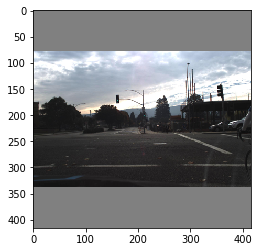

In [368]:
import matplotlib.pyplot as plt

I = './object-dataset/1478899999620519617.jpg '
B = '696,666,746,706,1 716,364,778,492,0 952,520,996,612,0 1158,630,1200,730,2 '
BB = '1320,620,1366,722,2 1542,594,1748,714,1 1774,414,1918,1170,3 1792,470,1914,1174,3'
IB = I + B + BB

annotation_line = IB
input_shape = (416, 416)

img, bbox = get_augmented_data(annotation_line, input_shape, augment=False)

print(bbox)
plt.imshow(img)

# Train

- Dataloader
- Optimizer
- Checkpoint
- Datagenerator

In [428]:
import os
import time

from six.moves import cPickle

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer(object):
    """
    Trainer to train MobileNetV2-YOLOv3 object detector.
    """
    def __init__(self, opt):
        self.opt = opt
        self.anchors = opt.anchors
        self.n_classes = opt.n_classes
        self.augment = opt.augment
        self.batch_size = opt.batch_size
        self.input_shape = opt.input_shape
        self.annotation_file = opt.annotation_file
        self.display_interval = opt.display_interval
        self.val_split = opt.val_split
        self.checkpoint_path = opt.checkpoint_path
        self.load_best = opt.load_best
        self.model, self.info = self.create_model()
        self.otpimizer = self.get_optimizer(self.opt, self.model)
        
        # Start training
        self.start()
        
    def create_model(self):
        """
        Modified from: https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/main.py
        """
        model = YOLOv3Layer(self.opt)
        if self.opt.start_from != '':
            if self.opt.load_best_model == 1:
                model_path = os.path.join(self.checkpoint_path, 'MobileNetV2_YoloV3.pth')
                info_path = os.path.join(self.checkpoint_path, 'checkpoint_info.pkl')
            else:
                epoch = self.opt.start_epoch
                model_path = os.path.join(self.checkpoint_path, 'MobileNetV2_YoloV3_{}.pth'.format(epoch))
                info_path = os.path.join(self.checkpoint_path, 'checkpoint_info_{}.pth'.format(epoch))
                
            with open(info_path, 'rb') as f:
                info = cPickle.load(f)
                
            model.load_state_dict(torch.load(model_path))
            
        if self.opt.use_cuda:
            model = model.cuda()
        
        return model, info
    
    def data_generator(self, annotation_lines):
        """
        Reference function: 
            https://github.com/qqwweee/keras-yolo3/blob/master/train.py
        """
        n = len(annotation_lines)
        i = 0
        while True:
            image_data = []
            bbox_data = []
            for b in range(self.batch_size):
                if i == 0:
                    np.random.shuffle(annotation_lines)
                image, bboxes = get_augmented_data(annotation_lines[i], 
                                                   self.input_shape, 
                                                   augment=self.augment)
                
                image_data.append(image)
                bbox_data.append(bboxes)
                i = (i+1) % n
            image_data = np.array(image_data)
            bbox_data = np.array(bbox_data)
            y_true = preprocess_true_boxes(bbox_data, self.input_shape, self.anchors, 
                                           self.n_classes)
            
            yield [image_data, *y_true], np.zeros(batch_size)
    
    def data_generator_wrapper(self, annotation_lines):
        """
        Reference function: 
            https://github.com/qqwweee/keras-yolo3/blob/master/train.py
        """
        n = len(annotation_lines)
        if n == 0 or batch_size <= 0:
            return None
        return self.data_generator(annotation_lines)
    
    def generate_data(self):
        """
        Generates train and val data based on validation split.
        """
        with open(self.annotation_file) as f:
            annotation_lines = f.readlines()
            
        # Shuffle the annotation lines
        np.random.shuffle(annotation_lines)
        
        # Compute splitting lengths
        n_val = int(len(annotation_lines) * self.val_split)
        n_train = len(annotation_lines) - n_val
        
        # Train and val data generators
        train_gen = self.data_generator_wrapper(annotation_lines[:n_train])
        val_gen = self.data_generator_wrapper(annotation_lines[n_train:])
        
        return n_train, train_gen, n_val, val_gen
    
    @staticmethod
    def get_optimizer(opt, net):
        params = []
        for key, value in dict(net.named_parameters()).items():
            if value.requires_grad:
                if 'base' in key:
                    params += [{'params': [value], 'lr': opt.base_lr}]
                else:
                    params += [{'params': [value], 'lr': opt.lr}]
                    
        # Initialize optimizer class: ADAM or SGD (w/wo nesterov)
        if opt.optimizer == 'adam':
            optimizer = optim.Adam(params=params, weight_decay=opt.weight_decay)
        else:
            optimizer = optim.SGD(params=params, momentum=0.9, 
                                  weight_decay=opt.weight_decay,
                                  nesterov=(opt.optimizer == 'nesterov'))
            
        return optimizer
    
    def save_checkpoint(self, epoch, best_val_loss, best_flag=False):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)
        checkpoint_name = 'MobileNetV2_YoloV3_{}.pth'.format(epoch)
        checkpoint_info = {
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Save checkpoint and checkpoint info
        torch.save(self.model.state_dict(), 
                   os.path.join(self.checkpoint_path, checkpoint_name))
        
        with open(os.path.join(self.checkpoint_path, 'checkpoint_info_{}.pkl'.format(epoch)), 'wb') as f:
            cPickle.dump(checkpoint_info, f)
            
        # Save best model
        if best_flag:
            torch.save(self.model.state_dict(), 
                       os.path.join(self.checkpoint_path, 'MobileNetV2_YoloV3.pth'))
        
            with open(os.path.join(self.checkpoint_path, 'checkpoint_info.pkl'), 'wb') as f:
                cPickle.dump(checkpoint_info, f)
                
    def train(self, n_train, train_gen, epoch):
        """
        Reference function:
            https://github.com/jiasenlu/YOLOv3.pytorch/blob/master/main.py
        """
        # Display string
        display = '>>> step: {}/{} (epoch: {}), loss: {:f}, lr: {:f}, time/batch {:.3f}'
        
        # Set gradient calculation to on
        torch.set_grad_enabled(mode=True)
        
        # Set model mode to train (default is train, but calling it explicitly)
        self.model.train()
        
        temp_losses = 0
        n_batches = int(n_train/self.batch_size)
        
        start = time.time()
        for batch in range(n_batches):
            img, y13, y26, y52 = next(train_gen)
            # Using CUDA as default for now
            img = torch.from_numpy(img).cuda()
            # PyTorch -> Channel first
            img = img.view(img.shape[0], img.shape[1], img.shape[2], img.shape[3]).permute(0, 3, 1, 2).contiguous()
            y13 = torch.from_numpy(y13).cuda()
            y26 = torch.from_numpy(y26).cuda()
            y52 = torch.from_numpy(y52).cuda()
            
            # Forward pass and compute loss
            losses = self.model(img, y13, y26, y52)
            
            # Get total loss
            loss = losses[0].sum() / losses[0].numel()
            loss = loss.sum() / loss.numel()
            
            temp_losses = temp_losses + loss.item()
            
            # Backward pass and update weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if batch % self.display_interval == 0 and batch != 0:
                end = time.time()
                temp_losses = temp_losses / self.display_interval
                print(display.format(batch, n_batches, epoch, temp_losses, optimizer.param_groups[-1]['lr'],
                                     (end-start)/self.display_interval))
                
                # Reset temp losses and time
                temp_losses = 0
                start = time.time()
    
    def validate(self, n_val, val_gen, epoch):
        # Display string
        display = '>>> Evaluation loss (epoch: {}): {:.3f}'
        
        # Set gradient calculation to off
        torch.set_grad_enabled(mode=False)
        
        # Set model mode to eval
        self.model.eval()
        
        temp_losses = 0
        n_batches = int(n_val/self.batch_size)
        
        for batch in range(n_batches):
            img, y13, y26, y52 = next(train_gen)
            # Using CUDA as default for now
            img = torch.from_numpy(img).cuda()
            # PyTorch -> Channel first
            img = img.view(img.shape[0], img.shape[1], img.shape[2], img.shape[3]).permute(0, 3, 1, 2).contiguous()
            y13 = torch.from_numpy(y13).cuda()
            y26 = torch.from_numpy(y26).cuda()
            y52 = torch.from_numpy(y52).cuda()
            
            # Forward pass and compute loss
            losses = self.model(img, y13, y26, y52)
            
            # Get total loss
            loss = losses[0].sum() / losses[0].numel()
            temp_losses = temp_losses + loss.item()
            
        # Loss
        temp_losses = temp_losses / n_batches
        
        print('=' * (len(display) + 10))
        print(display.format(epoch, temp_losses))
        print('=' * (len(display) + 10))
        
        return temp_losses
        
    def start(self):
        """
        Setup and start training
        """
        n_train, train_gen, n_val, val_gen = self.generate_data()
        
        # Scheduler to reduce learning rate when a metric has stopped improving
        scheduler = ReduceLROnPlateau(self.optimizer, patience=3, verbose=True)
        
        # Start training
        start_epoch = self.info.get('epoch', self.opt.start_epoch)
        best_val_loss = self.info.get('best_val_loss', 1e6)
        
        for epoch in range(self.opt.max_epochs):
            
            # Train
            self.train(n_train, train_gen, epoch)
            
            # Evaluate on validation set
            val_loss = self.validate(n_val, val_gen, epoch)
            
            # Scheduler step
            scheduler.step(val_loss)
            
            # Save checkpoint
            best_flag = False
            if best_val_loss is None or val_loss < best_val_loss:
                best_val_loss = val_loss # Update best validation loss 
                best_flag = True
                
            self.save_checkpoint(epoch, best_val_loss, best_flag)

In [427]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(params=[{'params': [torch.randn(3, 4)]}], lr=0.1)
step_scheduler = StepLR(optimizer, step_size=10)
rop_scheduler = ReduceLROnPlateau(optimizer)

In [394]:
import time

di = 5
nb = 20
tl = 0
for b in range(nb):
    ll = torch.randn(5)
    l = ll.sum()/ll.numel()
    l = l.sum()/l.numel()
    tl += l.item()
    
    print('b: ', b % di)
    if b % di == 0 and b != 0:
        print('tl: ', tl)
        tl = tl / di
        print('tl/di: ', tl)
        tl = 0

b:  0
b:  1
b:  2
b:  3
b:  4
b:  0
tl:  -1.7235528454184532
tl/di:  -0.34471056908369063
b:  1
b:  2
b:  3
b:  4
b:  0
tl:  -0.07040178775787354
tl/di:  -0.014080357551574708
b:  1
b:  2
b:  3
b:  4
b:  0
tl:  1.261252739932388
tl/di:  0.2522505479864776
b:  1
b:  2
b:  3
b:  4


In [429]:
class ModelTrainConfig():
    """
    Configuration for training MobileNetV2-YOLOv3 model
    """
    def __init__(self):
        # MobileNetV2 parameters
        # ----------------------
        # Conv and Inverted Residual Parameters: Table-2 (https://arxiv.org/pdf/1801.04381.pdf)
        self.t = [1, 1, 6, 6, 6, 6, 6, 6]  # t: expansion factor
        self.c = [32, 16, 24, 32, 64, 96, 160, 320]  # c: Output channels
        self.n = [1, 1, 2, 3, 4, 3, 3, 1]  # n: Number of times layer is repeated
        self.s = [2, 1, 2, 2, 2, 1, 2, 1]  # s: Stride
        # Width multiplier: Controls the width of the network
        self.alpha = 1.0
        
        # YOLOv3 parameters
        # -----------------
        self.n_classes = 5  # Udacity Self-driving car dataset
        self.class_map = {0: 'bike', 1: 'car', 2: 'pedestrian', 3: 'signal', 4: 'truck'}
        self.class_names = ['bike', 'car', 'pedestrian', 'signal', 'truck']
        self.final_channels = 3 * (5 + self.n_classes)
        self.input_size = (416, 416)
        self.anchors = [[10, 13], [16, 30], [33, 23], 
                        [30, 61], [62, 45], [59, 119], 
                        [116, 90], [156, 198], [373, 326]]
        
        # Training parameters
        # -------------------
        self.use_cuda = True
        self.optimizer == 'sgd' # 'adam' or 'sgd' or 'nesterov'
        self.weight_decay = 0
        self.max_epochs = 150
        
        # Dataset parameters
        # ------------------
        self.val_split = 0.1
        self.augment = True  # Horizontal flip, scale and HSV
        self.batch_size = 32
        self.annotation_file = './annotations.csv'
        
        # Terminal display
        # ----------------
        self.display_interval = 5
        
        # Checkpoint config
        # -----------------
        self.start_epoch = 0
        self.start_from = '' # '' or 'best'
        self.checkpoint_path = './checkpoints'
        self.load_best_model = False

# Inference

In [472]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function makes sure that number of channels number is divisible by 8.
    Source: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBnReLU(nn.Module):
    """
    [CONV]-[BN]-[ReLU6]
    """

    def __init__(self, inCh, outCh, stride):
        super(ConvBnReLU, self).__init__()
        self.inCh = inCh  # Number of input channels
        self.outCh = outCh  # Number of output channels
        self.stride = stride  # Stride
        self.conv = nn.Sequential(
            nn.Conv2d(self.inCh, self.outCh, 3, stride=self.stride, padding=1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InvertedResidual(nn.Module):
    """
    [CONV_1x1-BN-ReLU6]-[CONV_3x3-BN-ReLU6]-[CONV_1x1-BN] with identity shortcut.
    """

    def __init__(self, inCh, outCh, t, s):
        super(InvertedResidual, self).__init__()
        self.inCh = inCh
        self.outCh = outCh
        self.t = t  # t: expansion factor
        self.s = s  # s: Stride
        self.identity_shortcut = (self.inCh == self.outCh) and (self.s == 1)  # L:506 Keras official code

        # Bottleneck block
        self.block = nn.Sequential(
            # Expansition Conv
            nn.Conv2d(self.inCh, self.t * self.inCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.t * self.inCh),
            nn.ReLU6(inplace=True),

            # Depthwise Conv
            nn.Conv2d(self.t * self.inCh, self.t * self.inCh, kernel_size=3, stride=self.s, padding=1, 
                      groups=self.t * self.inCh, bias=False),
            nn.BatchNorm2d(self.t * self.inCh),
            nn.ReLU6(inplace=True),

            # Pointwise Linear Conv (Projection): i.e. No non-linearity
            nn.Conv2d(self.t * self.inCh, self.outCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.outCh),
        )

    def forward(self, x):
        if self.identity_shortcut:
            return x + self.block(x)
        else:
            return self.block(x)


class PointwiseConv(nn.Module):
    def __init__(self, inCh, outCh):
        super(PointwiseConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inCh, outCh, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# MobileNetV2
class MobileNetV2(nn.Module):
    """
    MobileNetV2 feature extractor for YOLOv3. NOTE: YOLOv3 uses convolutional layers only!

    Input: 416 x 416 x 3
    Last layer Pointwise conv output:13 x 13 x 1024 -> Large object detection
    5th layer Pointwise conv output: :26 x 26 x 512 -> Medium object detection
    3rd layer Pointwise conv output: 52 x 52 x 256 -> Small object detection
    """

    def __init__(self, params):
        super(MobileNetV2, self).__init__()
        self.params = params
        self.first_inCh = 3
        last_outCh = 1280

        self.c = [_make_divisible(c * self.params.alpha, 8) for c in self.params.c]
        # Last convolution has 1280 output channels for alpha <= 1
        self.last_outCh = _make_divisible(int(last_outCh * self.params.alpha),
                                          8) if self.params.alpha > 1.0 else last_outCh

        # NOTE: YOLOv3 makes predictions at 3 different scales: (1) In the last feature map layer: 13 x 13
        # (2) The feature map from 2 layers previous and upsample it by 2x: 26 x 26
        # (3) The feature map from 2 layers previous and upsample it by 2x: 52 x 52

        # Layer-0
        self.layer0 = nn.Sequential(ConvBnReLU(self.first_inCh, self.c[0], self.params.s[0]))

        # Layer-1
        self.layer1 = self._make_layer(self.c[0], self.c[1], self.params.t[1], self.params.s[1], self.params.n[1])

        # Layer-2
        self.layer2 = self._make_layer(self.c[1], self.c[2], self.params.t[2], self.params.s[2], self.params.n[2])

        # Layer-3
        self.layer3 = self._make_layer(self.c[2], self.c[3], self.params.t[3], self.params.s[3], self.params.n[3])
        self.layer3_out = nn.Sequential(PointwiseConv(self.c[3], 256))

        # Layer-4
        self.layer4 = self._make_layer(self.c[3], self.c[4], self.params.t[4], self.params.s[4], self.params.n[4])

        # Layer-5
        self.layer5 = self._make_layer(self.c[4], self.c[5], self.params.t[5], self.params.s[5], self.params.n[5])
        self.layer5_out = nn.Sequential(PointwiseConv(self.c[5], 512))

        # Layer-6
        self.layer6 = self._make_layer(self.c[5], self.c[6], self.params.t[6], self.params.s[6], self.params.n[6])

        # Layer-7
        self.layer7 = self._make_layer(self.c[6], self.c[7], self.params.t[7], self.params.s[7], self.params.n[7])

        # Layer-8
        self.layer8 = nn.Sequential(PointwiseConv(self.c[7], self.last_outCh))

        self.out_channels = [256, 512, 1280]
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, inCh, outCh, t, s, n):
        layers = []
        for i in range(n):
            # First layer of each sequence has a stride s and all others use stride 1
            if i == 0:
                layers.append(InvertedResidual(inCh, outCh, t, s))
            else:
                layers.append(InvertedResidual(inCh, outCh, t, 1))

            # Update input channel for next IRB layer in the block
            inCh = outCh
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        out52 = self.layer3_out(x)
        x = self.layer4(x)
        x = self.layer5(x)
        out26 = self.layer5_out(x)
        x = self.layer6(x)
        x = self.layer7(x)
        out13 = self.layer8(x)
        return out52, out26, out13
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [473]:
class ModelDetectConfig():
    """
    Configuration for object detection via MobileNetV2-YOLOv3 model
    """
    def __init__(self):
        # MobileNetV2 parameters
        # ----------------------
        # Conv and Inverted Residual Parameters: Table-2 (https://arxiv.org/pdf/1801.04381.pdf)
        self.t = [1, 1, 6, 6, 6, 6, 6, 6]  # t: expansion factor
        self.c = [32, 16, 24, 32, 64, 96, 160, 320]  # c: Output channels
        self.n = [1, 1, 2, 3, 4, 3, 3, 1]  # n: Number of times layer is repeated
        self.s = [2, 1, 2, 2, 2, 1, 2, 1]  # s: Stride
        # Width multiplier: Controls the width of the network
        self.alpha = 1.0
        
        # YOLOv3 parameters
        # -----------------
        self.n_classes = 5  # Udacity Self-driving car dataset
        self.class_map = {0: 'bike', 1: 'car', 2: 'pedestrian', 3: 'signal', 4: 'truck'}
        self.final_channels = 3 * (5 + self.n_classes)
        self.input_shape = (416, 416)
        self.anchors = [[10, 13], [16, 30], [33, 23], 
                        [30, 61], [62, 45], [59, 119], 
                        [116, 90], [156, 198], [373, 326]]
        
        # Detect parameters
        # -----------------
        self.checkpoint_path = './checkpoints'
        
params = ModelDetectConfig()